# Регрессия и scikit-learn

Библиотека scikit-learn — это популярная библиотека языка Python для машинного обучения.

Рассмотрим метеорологические данные города Сегед (Szeged) в Венгрии (Hungary) за 2006-2016 года*.

---
\* https://www.kaggle.com/budincsevity/szeged-weather

<img src="http://investinszeged.hu/en/wp-content/uploads/2017/09/magyarorszag_fekvese.jpg">

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Предобработка и визуализация данных 

In [2]:
df = pd.read_csv('weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
df.shape

(96453, 12)

Столбец `Loud Cover`, кажется, не имеет значений, отличных от нуля. Проверим это.

In [4]:
all(df['Loud Cover'] == 0)

True

Действительно. Поскольку он этими данными не представляет интереса, удалим его из таблицы.

In [5]:
df.drop('Loud Cover', axis=1, inplace=True)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.


Посмотрим информацию о нашей таблице.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null object
Precip Type                 95936 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null float64
Visibility (km)             96453 non-null float64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
dtypes: float64(7), object(4)
memory usage: 8.1+ MB


Обратим внимание на количество памяти, которое используется для хранения таблицы. Попробуем его сократить. Во-первых, поменяем тип данных float64 на float32.

In [7]:
df['Temperature (C)'] = df['Temperature (C)'].astype('float32')
df['Apparent Temperature (C)'] = df['Apparent Temperature (C)'].astype('float32')
df['Humidity'] = df['Humidity'].astype('float32')
df['Wind Speed (km/h)'] = df['Wind Speed (km/h)'].astype('float32')
df['Wind Bearing (degrees)'] = df['Wind Bearing (degrees)'].astype('float32')
df['Visibility (km)'] = df['Visibility (km)'].astype('float32')
df['Pressure (millibars)'] = df['Pressure (millibars)'].astype('float32')

Во-вторых, попробуем определить категориальные признаки и поменять их тип на category.

In [8]:
df.describe(include='object')

,Formatted Date,Summary,Precip Type,Daily Summary
count,96453,96453,95936,96453
unique,96429,27,2,214
top,2010-08-02 15:00:00.000 +0200,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,2,31733,85224,20085


In [9]:
df['Precip Type'] = df['Precip Type'].astype('category')
df['Summary'] = df['Summary'].astype('category')
df['Daily Summary'] = df['Daily Summary'].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null category
Precip Type                 95936 non-null category
Temperature (C)             96453 non-null float32
Apparent Temperature (C)    96453 non-null float32
Humidity                    96453 non-null float32
Wind Speed (km/h)           96453 non-null float32
Wind Bearing (degrees)      96453 non-null float32
Visibility (km)             96453 non-null float32
Pressure (millibars)        96453 non-null float32
Daily Summary               96453 non-null category
dtypes: category(3), float32(7), object(1)
memory usage: 3.7+ MB


Количество затрачиваемой на хранение памяти сократилось более, чем вдвое. Рассмотрим статистические данные нашей таблицы.

In [11]:
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932567,10.855006,0.734917,10.811157,187.509064,10.348932,1003.228516
std,9.551455,10.696870,0.195479,6.913508,107.381935,4.192387,116.965302
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,1011.900024
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,1016.450012
75%,18.838888,18.838888,0.890000,14.135800,290.000000,14.812000,1021.090027
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380005


Бросается в глаза минимальное значение некоторых столбцов. Например, влажность (Humidity) и давление (Pressure (millibars)). По всей видимости, в это время измерения данных величин не проводились. Но оставим пока так, как есть.

Рассмотрим корреляционную матрицы нашх данных. Коэффициент корреляции показывает линейную зависимость переменных. Похоже, что наиболее всего коррелируют значения температуры и влажности.

In [12]:
df.corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000


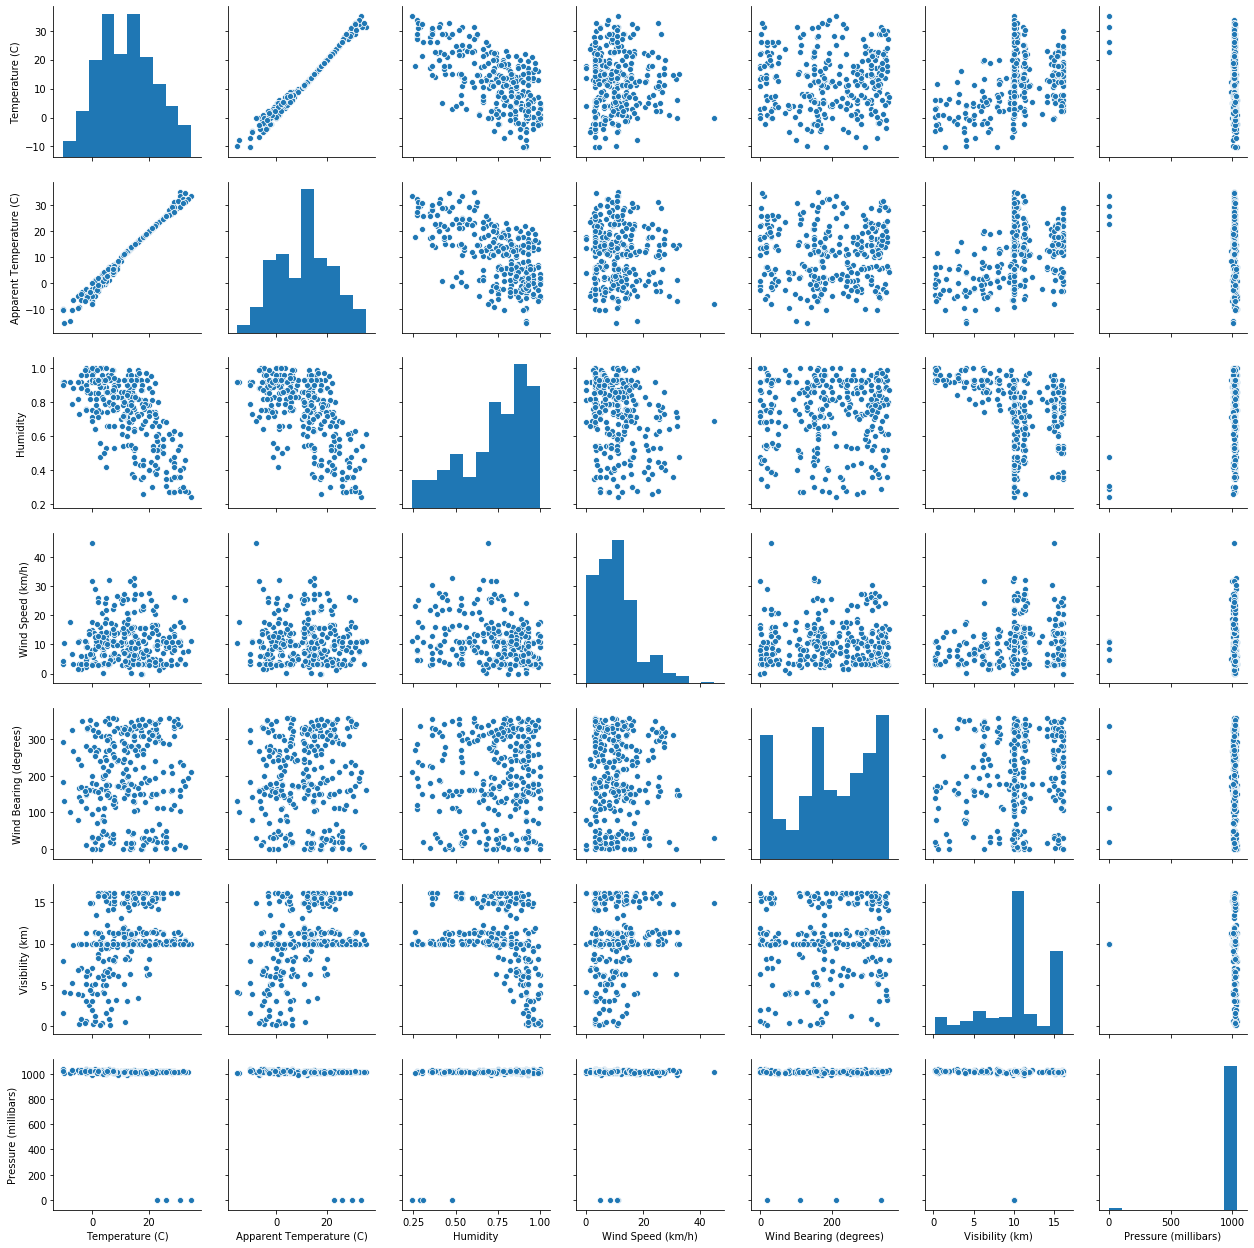

In [13]:
sns_plot = sns.pairplot(df.sample(300).dropna())

Это же видно и на данных графиках. То есть, графики влажности и температуры вытягиваются в некоторую линию и проявляют закономерность.

## Линейная регрессия

Рассмотрим эти переменные и построим модель линейной регрессии с помощью библиотеки scikit-learn, чтобы уметь предсказывать температуру по значению влажности.

Функция `fit_regression_model()` возвращает модель линейной регрессии `model`, обученную на данных `x`.

Функция `model_evaluation()` выводит значения среднеквадратической ошибки $MSE$ и $R^2$, получаемые при сравнении с истинными значениями `y_true` и предсказанными значениями `y_predict`.

In [14]:
def fit_regression_model(x, y):    
    lm = LinearRegression()
    lm.fit(x, y)    
    return lm

In [15]:
def model_evaluation(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    r2 = r2_score(y_true, y_predict)
    print('MSE =', mse)
    print('R^2 =', r2)

In [16]:
def regression_plot(x, y_true, y_predict, title='Regression plot'):
    x_sort, y_sort = zip(*sorted(zip(list(x.iloc[:, 0]), y_predict)))
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y_true, color='darkblue')
    plt.plot(x_sort, y_sort, color='orange', linewidth=3)
    plt.xlabel(x.columns[0])
    plt.ylabel(y_true.name)
    plt.title(title)
    plt.show()

In [17]:
x_data = df[['Humidity']]
y_data = df['Temperature (C)']

Разделим наши данные на обучающую и тестовую выборки по принципу 70%/30%.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

print("Number of test samples :", x_test.shape[0])
print("Number of training samples:",x_train.shape[0])

Number of test samples : 28936
Number of training samples: 67517


Создаем и тренируем модель линейной регрессии на обучающей выборке.

In [19]:
lm = fit_regression_model(x_train, y_train)

print('Temperature (C) = {0} + {1} Humidity'.format(lm.intercept_, lm.coef_[0]))

Temperature (C) = 34.58505630493164 + -30.817432403564453 Humidity


Обученную модель применим к тестовой выборке и получим предсказанные значения.

In [20]:
y_hat = lm.predict(x_test)

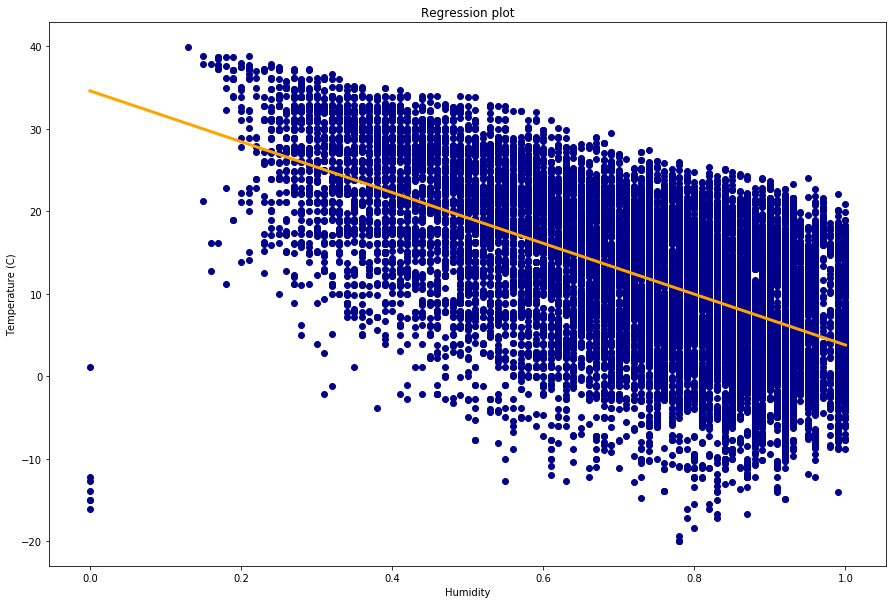

In [21]:
regression_plot(x_test, y_test, y_hat)

Посмотрим на значения среднеквадратической ошибки и $R^2$ нашей модели на тестовых данных.

In [22]:
model_evaluation(y_test, y_hat)

MSE = 54.585712
R^2 = 0.40422317693425835


Чем ближе значение $R^2$ к единице, тем лучше обучена модель.

## Полиномиальная регрессия

Рассмотрим полиномиальную регрессию. Функция `polynomial_transformation()` принимает значения данных `x` и степень полинома `degree`, а возвращает преобразованные значения согласно указанной степени полинома. Используемая здесь функция `fit_transform()` позволяет преобразовать наши данные, получив все необходимые значения для полинома нужной степени. Таким образом, увеличивается размерность переменных, позволяя получить из них больше информации.

In [23]:
def polynomial_transformation(x, degree):
    pr = PolynomialFeatures(degree)
    x_pr = pr.fit_transform(x)
    return x_pr

Выберем степень полинома равной трем и преобразуем данные из обучающей и тестовой выборки.

In [24]:
degree = 3
x_train_pr = polynomial_transformation(x_train, degree)
x_test_pr = polynomial_transformation(x_test, degree)

Создадим и обучим модель полиномиальной регрессии.

In [25]:
poly = fit_regression_model(x_train_pr, y_train)

Получаем значения для данных из тестовой выборки.

In [26]:
y_hat_poly = poly.predict(x_test_pr)

Оцениваем качество обученной модели.

In [27]:
model_evaluation(y_test, y_hat_poly)

MSE = 53.894511624928484
R^2 = 0.4117672745810569


Оценка модели улучшилась незначительно. Посмотрим, как это выглядит на графике.

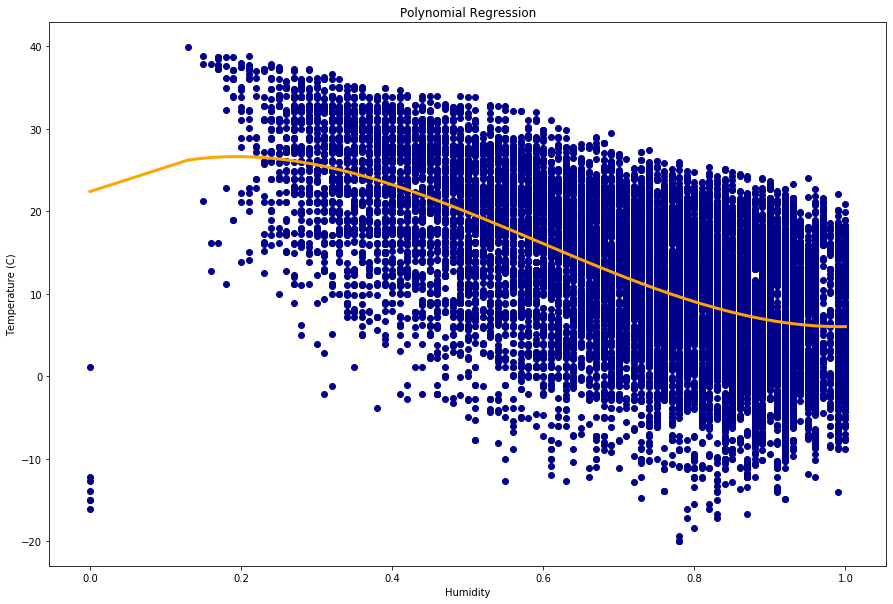

In [28]:
regression_plot(x_test, y_test, y_hat_poly, 'Polynomial Regression')

Похоже, что некоторые ошибки появляются из-за значений температуры, соответствующих нулевой влажности. Поскольку таких значений не так много, просто удалим строки, в которых влажность равна нулю.

In [29]:
df[df['Humidity'] == 0].index

Int64Index([19958, 28101, 28103, 28110, 29627, 54840, 54858, 54870, 54872,
            54873, 55086, 55088, 55349, 55350, 55352, 55412, 55469, 55472,
            55473, 55481, 55508, 55511],
           dtype='int64')

In [30]:
df.drop(df[df['Humidity'] == 0].index, axis=0, inplace=True)

Рассмотрим также график, называемый "ящик с усами".

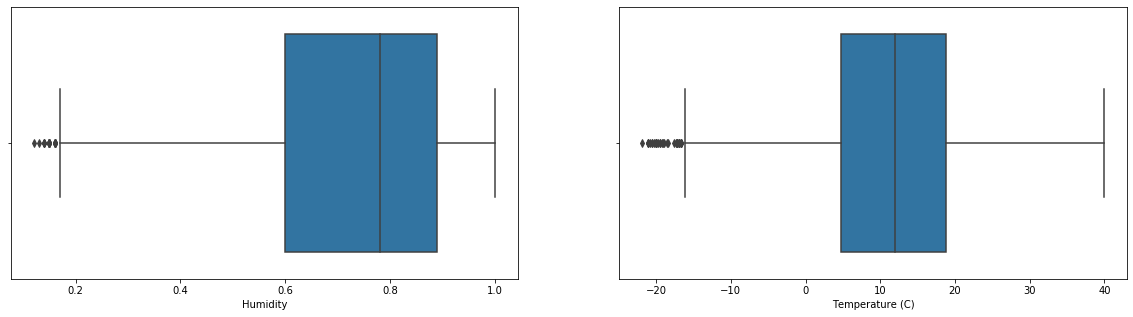

In [31]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(df['Humidity'])

ax2 = fig.add_subplot(1, 2, 2)
sns.boxplot(df['Temperature (C)'])

plt.show()

Значения, находящиеся за пределами "усов" называются выбросами. Удалим их из наших данных.

In [32]:
outlier_hum_val = df['Humidity'].quantile(q=0.25) - 1.5 * (df['Humidity'].quantile(q=0.75) - df['Humidity'].quantile(q=0.25))
outlier_hum_val

0.1650000810623169

In [33]:
outlier_temp_val = df['Temperature (C)'].quantile(q=0.25) - 1.5 * (df['Temperature (C)'].quantile(q=0.75) - df['Temperature (C)'].quantile(q=0.25))
outlier_temp_val

-16.494443655014038

In [34]:
df.drop((df[df['Humidity'] < outlier_hum_val].index | df[df['Temperature (C)'] < outlier_temp_val].index), axis=0, inplace=True)
df.shape

(96367, 11)

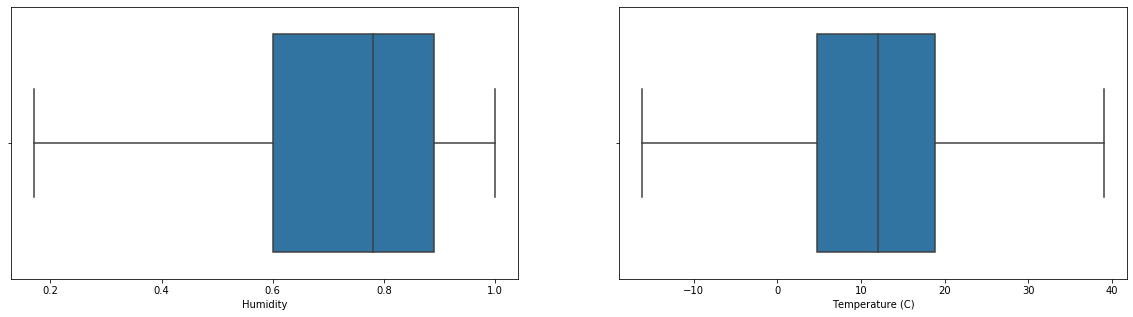

In [35]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(df['Humidity'])

ax2 = fig.add_subplot(1, 2, 2)
sns.boxplot(df['Temperature (C)'])

plt.show()

Снова разделим наши данные на обучающую и тестовую выборки.

In [36]:
x_data = df[['Humidity']]
y_data = df['Temperature (C)']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

print("Number of test samples :", x_test.shape[0])
print("Number of training samples:",x_train.shape[0])

Number of test samples : 28911
Number of training samples: 67456


Обучим модель полиномиальной регрессии на очищенных данных.

In [38]:
x_train_pr = polynomial_transformation(x_train, degree)
x_test_pr = polynomial_transformation(x_test, degree)

poly_1 = fit_regression_model(x_train_pr, y_train)

y_hat_poly_1 = poly_1.predict(x_test_pr)

model_evaluation(y_test, y_hat_poly_1)

MSE = 53.04871488041832
R^2 = 0.41544937981690144


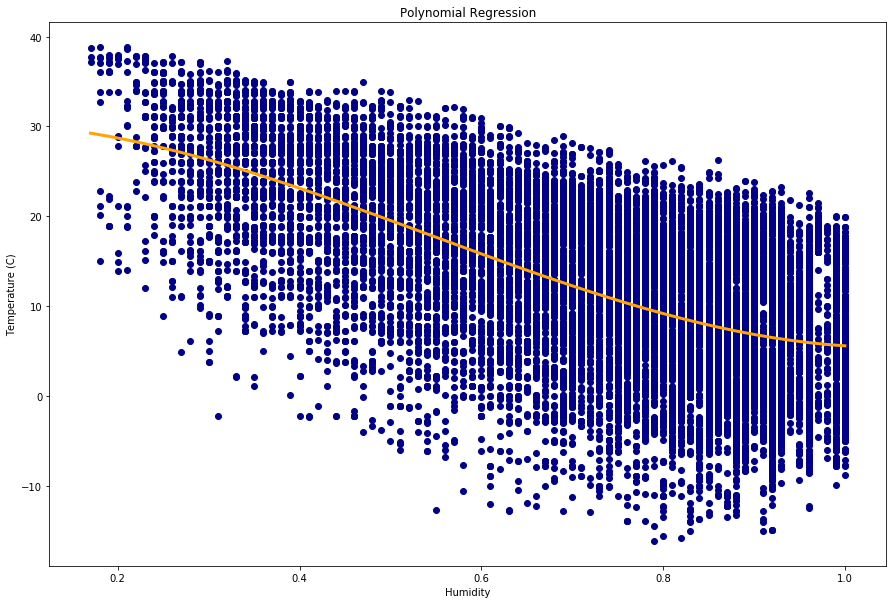

In [39]:
regression_plot(x_test, y_test, y_hat_poly_1, 'Polynomial Regression')

К сожалению, ожидаемых результатов это не принесло, несмотря на визуальное улучшение модели.

Рассмотрим ещё раз график зависимости температуры от атмосферного давления.

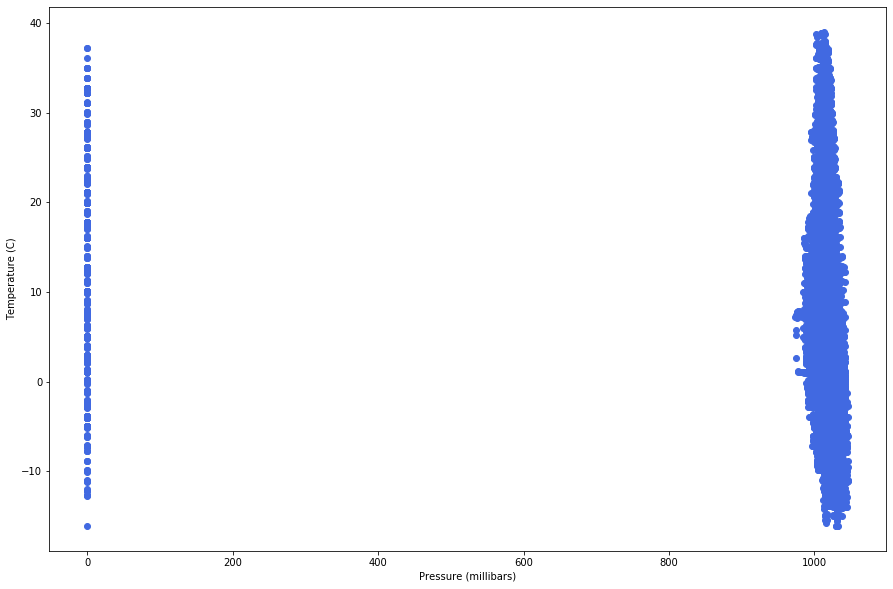

In [40]:
plt.figure(figsize=(15, 10))
plt.scatter(df['Pressure (millibars)'], df['Temperature (C)'], color='royalblue')
plt.xlabel('Pressure (millibars)')
plt.ylabel('Temperature (C)')
plt.show()

Нулевые значения, которые, судя по всему, означают отсутствие данных, не дают рассмотреть характер зависимости переменных.

In [41]:
df = df.drop(df[df['Pressure (millibars)'] == 0].index, axis=0)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.130005,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.630005,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.940002,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944445,0.83,14.1036,269.0,15.8263,1016.409973,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755555,6.977778,0.83,11.0446,259.0,15.8263,1016.510010,Partly cloudy throughout the day.


In [42]:
df.shape

(95079, 11)

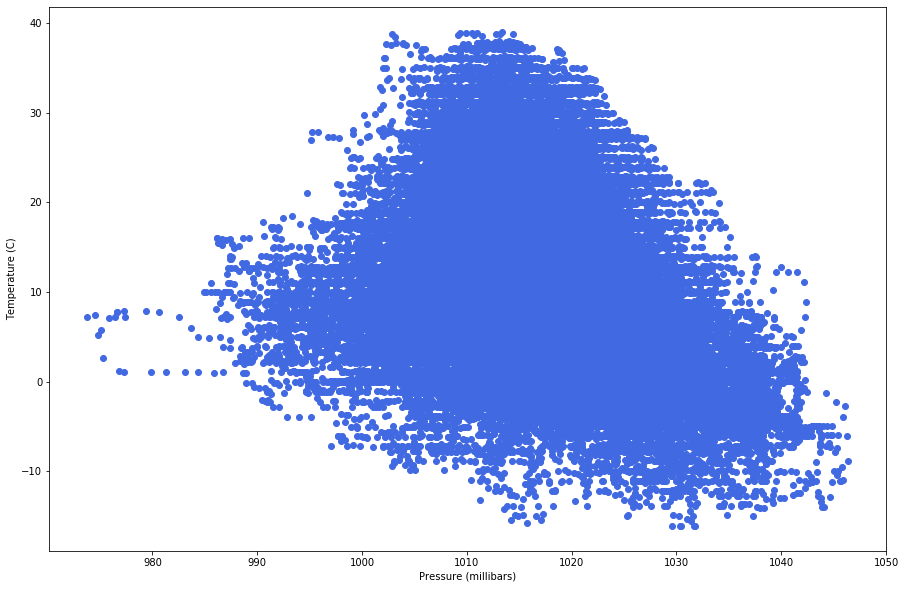

In [43]:
plt.figure(figsize=(15, 10))
plt.scatter(df['Pressure (millibars)'], df['Temperature (C)'], color='royalblue')
plt.xlabel('Pressure (millibars)')
plt.ylabel('Temperature (C)')
plt.show()

Включим теперь в нашу модель полиномиальной регрессии новую переменную - давление.

In [44]:
x_data = df[['Humidity', 'Pressure (millibars)']]
y_data = df['Temperature (C)']

Как и раньше, разделим данные на обучающую и тестовую выборки по принципу 70%/30%.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

print("Number of test samples :", x_test.shape[0])
print("Number of training samples:",x_train.shape[0])

Number of test samples : 28524
Number of training samples: 66555


In [46]:
x_train_pr = polynomial_transformation(x_train, degree)
x_test_pr = polynomial_transformation(x_test, degree)

poly_2 = fit_regression_model(x_train_pr, y_train)

y_hat_poly_2 = poly_2.predict(x_test_pr)

model_evaluation(y_test, y_hat_poly_2)

MSE = 41.642897940109506
R^2 = 0.5403337236923647


Среднеквадратическая ошибка уменьшилась более, чем на $10$, то есть чуть более чем на $\sqrt{10}$ градусов Цельсия.

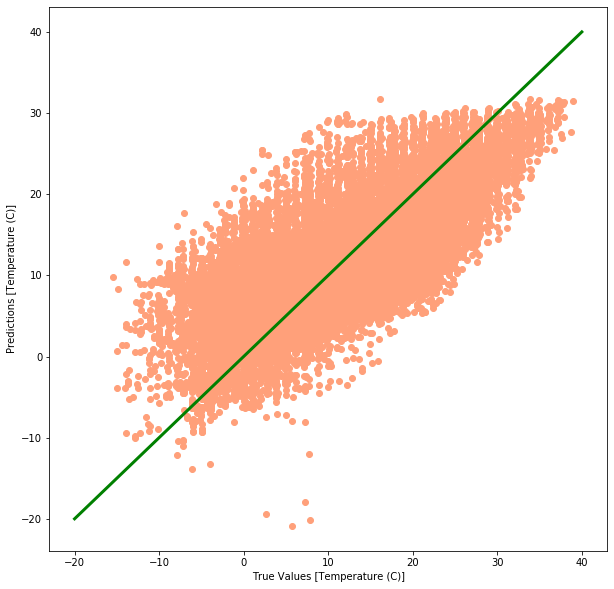

In [47]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_hat_poly_2, color='lightsalmon')
plt.plot([-20, 40], [-20, 40], color='green', linewidth=3)
plt.xlabel('True Values [Temperature (C)]')
plt.ylabel('Predictions [Temperature (C)]')
plt.show()

## Pipeline

Теперь попробуем использовать все числовые переменные (кроме ощущаемой температуры) для обучения модели полиномиальной регрессии с помощью инструмента Pipeline.

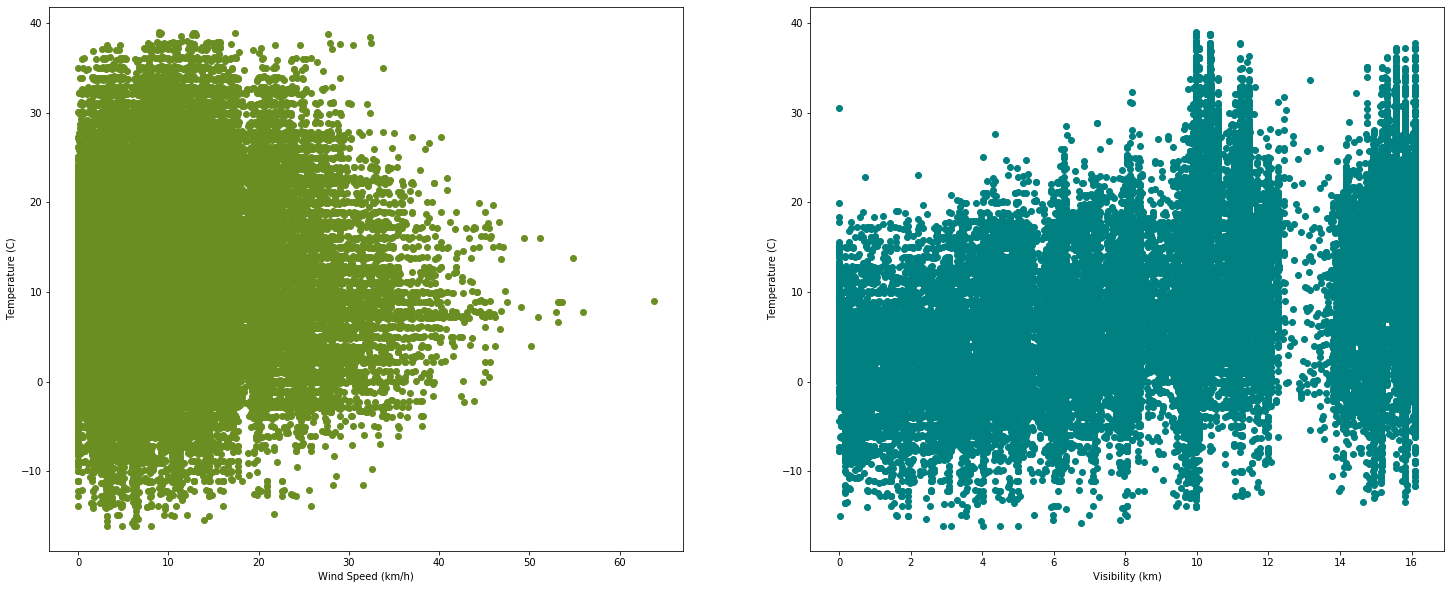

In [48]:
fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(df['Wind Speed (km/h)'], df['Temperature (C)'], color='olivedrab')
ax1.set_xlabel('Wind Speed (km/h)')
ax1.set_ylabel('Temperature (C)')

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(df['Visibility (km)'], df['Temperature (C)'], color='teal')
ax2.set_xlabel('Visibility (km)')
ax2.set_ylabel('Temperature (C)')

plt.show()

In [49]:
x_data = df[['Humidity', 'Pressure (millibars)', 'Wind Speed (km/h)', 'Visibility (km)']]
y_data = df['Temperature (C)']

Как и ранее, разделяем данные на обучающую и тестовую выборки.

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

print("Number of test samples :", x_test.shape[0])
print("Number of training samples:",x_train.shape[0])

Number of test samples : 28524
Number of training samples: 66555


Функция `make_pipeline()` создает и возвращает объект класса Pipeline из библиотеки Scikit-learn, который позволяет упростить настройку параметров модели. В данном случае я использую `StandartScaler()` для нормировки (или стандартизации) данных, что не делалось ранее, `PolynomialFeatures()` для преобразования данных в соответствии со степенью полинома и `LinearRegression()` для создания модели регрессии.

In [51]:
def make_pipeline(x, y, degree):
    pipe = Pipeline([('scale', StandardScaler()), ('polynomial', PolynomialFeatures(degree)), ('model', LinearRegression())])
    pipe.fit(x, y)
    return pipe

In [52]:
pipe = make_pipeline(x_train, y_train, degree)

y_hat_pipe = pipe.predict(x_test)

model_evaluation(y_test, y_hat_pipe)

MSE = 34.72176372572891
R^2 = 0.6167311923969966


Значение среднеквадратической ошибки уменьшилось уже до ~35, что говорит об улучшении качества модели.